Here we'll first be loading the FC matrices and explore their structure

In [6]:
#using read_dataset from Datasets/FC/create_dataset.py to read the dataset
from Datasets.FC.create_dataset import read_dataset_MDD
import torch 
print('GPU available?', torch.cuda.is_available())

GPU available? False


In [7]:
dataset = read_dataset_MDD()

In [8]:
#ok, let's explore the data a bit more
#dataset is a list object of torch_geometric.data objects

#let's see the first element
print(dataset[0])

#it's a dictionary object, let's see the keys
print(dataset[0].keys())

#ok, let's see the values
print(dataset[0].values())

#it has 4 keys, 'x', 'edge_index', 'edge_attr' and 'y' where y=0 menas the patient is healthy and y=1 means the patient has MDD
"""graph = Data(x=ROI.reshape(-1,116).float(),
                     edge_index=G.indices().reshape(2,-1).long(),
                     edge_attr=G.values().reshape(-1,1).float(),
                     y=y.long())"""

#how much data do we have?
print('Number of samples:', len(dataset))


Data(x=[116, 116], edge_index=[2, 1294], edge_attr=[1294, 1], y=[1])
['y', 'edge_attr', 'edge_index', 'x']
ValuesView({'x': tensor([[ 0.0000,  0.2857,  0.0804,  ...,  0.2032,  0.1674,  0.0906],
        [ 0.2857,  0.0000, -0.3860,  ...,  0.1637, -0.0359,  0.1674],
        [ 0.0804, -0.3860,  0.0000,  ..., -0.0175, -0.0309,  0.0296],
        ...,
        [ 0.2032,  0.1637, -0.0175,  ...,  0.0000,  0.2329, -0.1452],
        [ 0.1674, -0.0359, -0.0309,  ...,  0.2329,  0.0000,  0.0183],
        [ 0.0906,  0.1674,  0.0296,  ..., -0.1452,  0.0183,  0.0000]]), 'edge_index': tensor([[  0,   0,   0,  ..., 113, 113, 114],
        [ 10,  12,  14,  ..., 111, 112, 108]]), 'edge_attr': tensor([[0.7785],
        [0.6966],
        [0.5463],
        ...,
        [0.6415],
        [0.4745],
        [0.5401]]), 'y': tensor([0])})
Number of samples: 1604


In [9]:
#set the seed
import torch
torch.manual_seed(0)

MODEL = "GCN"
DATASET = "FC_MDD"

from models.models_FC import GCN_framework as framework # import the model

gnn = framework(dataset,device="cpu")

print(gnn.model)
print(gnn.train_idx)

Net(
  (conv_layers): ModuleList(
    (0): GCNConv(116, 128)
    (1-4): 4 x GCNConv(128, 128)
  )
  (batch_norms): ModuleList(
    (0-4): 5 x BatchNorm(128)
  )
  (lin1): Linear(128, 128, bias=True)
  (lin2): Linear(128, 2, bias=True)
  (bn1): BatchNorm(128)
  (bn2): BatchNorm(2)
)
tensor([1365,  984, 1017,  ...,  260,  678,   83])


c:\Users\tomdu\miniconda3\lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [5]:
gnn.iterate()

Epoch: 020, Loss: 0.110, Test Loss: 0.625, Train Acc: 1.000 Test Acc: 0.642
Epoch: 040, Loss: 0.090, Test Loss: 0.614, Train Acc: 1.000 Test Acc: 0.704
Epoch: 060, Loss: 0.077, Test Loss: 0.604, Train Acc: 1.000 Test Acc: 0.704
Epoch: 080, Loss: 0.070, Test Loss: 0.606, Train Acc: 1.000 Test Acc: 0.716
Epoch: 100, Loss: 0.064, Test Loss: 0.604, Train Acc: 1.000 Test Acc: 0.691
Epoch: 120, Loss: 0.062, Test Loss: 0.602, Train Acc: 1.000 Test Acc: 0.704
Epoch: 140, Loss: 0.059, Test Loss: 0.605, Train Acc: 1.000 Test Acc: 0.716


In [10]:
#gnn.train()

In [7]:
#save the model 
#gnn.save_model(path="models/"+DATASET+"_"+MODEL+"server.pt")

Model saved in: models/FC_MDD_GCNserver.pt


In [8]:
#save the model 
#gnn.save_model(path="models/"+DATASET+"_"+MODEL+"server.pt")

In [11]:
#load the model
gnn.load_model(path="models/"+DATASET+"_"+MODEL+"server.pt")

In [12]:
gnn.evaluate()

Test Loss: 0.605, Train Acc: 1.000 Test Acc: 0.716


In [13]:
train_features, test_features = gnn.evaluate_with_features2()

In [14]:
print(len(train_features[0]))
len(train_features), len(test_features)

8


(1523, 81)

In [15]:
import networkx as nx
def calculate_avg_path_length(G):
    if nx.is_connected(G):
        return nx.average_shortest_path_length(G)
    else:
        # Alternative metrics for disconnected graphs
        # Option 1: Use the average path length of the largest connected component
        components = [G.subgraph(c).copy() for c in nx.connected_components(G)]
        largest_component = max(components, key=len)
        return nx.average_shortest_path_length(largest_component)
    

def compute_graph_properties(data):
    properties = []
    for graph_data in data:
        G = nx.from_edgelist(graph_data.edge_index.t().tolist())
        num_nodes = G.number_of_nodes()
        num_edges = G.number_of_edges()
        density = nx.density(G)
        avg_path_len = calculate_avg_path_length(G)
        num_cliques = len(list(nx.find_cliques(G)))
        num_triangles = sum(nx.triangles(G).values()) / 3
        num_squares = sum(nx.square_clustering(G).values()) / 4
        number_of_node_in_the_largest_fully_connected_component = len(max(nx.connected_components(G), key=len))
        #small_world = nx.algorithms.smallworld.sigma(G)

        properties.append((num_nodes, num_edges, density, avg_path_len, num_cliques, num_triangles, num_squares, number_of_node_in_the_largest_fully_connected_component)) #, small_world))
    return properties

train_idx_list = gnn.train_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in train_idx_list]
train_properties = compute_graph_properties(selected_dataset)
test_idx_list = gnn.test_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in test_idx_list]
test_properties = compute_graph_properties(selected_dataset)

In [16]:
print(len(train_properties))
train_properties[0:5]



1523


[(116,
  488,
  0.07316341829085457,
  3.314842578710645,
  148,
  938.0,
  6.439699892510922,
  116),
 (114,
  598,
  0.0928427262847384,
  3.166744294364229,
  164,
  1378.0,
  7.519630514954544,
  114),
 (114,
  408,
  0.06334420121099209,
  3.391864617295451,
  135,
  511.0,
  5.279502013122494,
  114),
 (115,
  744,
  0.11350114416475973,
  2.796796338672769,
  198,
  1870.0,
  7.980704583203741,
  115),
 (112,
  706,
  0.11357786357786358,
  3.3745173745173744,
  181,
  2528.0,
  9.050100863174576,
  112)]

In [17]:
import pickle as pkl
# save the properties in a file
with open("results/"+DATASET+"_"+MODEL+"_train_properties.pkl", "wb") as f:
    pkl.dump(train_properties, f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties.pkl", "wb") as f:
    pkl.dump(test_properties, f)

#load the properties
with open("results/"+DATASET+"_"+MODEL+"_train_properties.pkl", "rb") as f:
    train_properties = pkl.load(f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties.pkl", "rb") as f:
    test_properties = pkl.load(f)

In [18]:
"""
The embeddings of GCN are like this:
return F.log_softmax(x7, dim=-1), (x1, x2, x3, x4, x5, x_global, x6, x7)
"""


import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
output_size = 1  # Predicting one property at a time
# Define the linear model
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Assume we have already evaluated to get features
#train_features, test_features = gnn.evaluate_with_features2()

# Extract x embeddings
train_x = np.array([feat[0] for feat in train_features])
test_x = np.array([feat[0] for feat in test_features])

# Extract 2, 3, 4, global, 5, 6, 7 embeddings
train_x2 = np.array([feat[1] for feat in train_features])
test_x2 = np.array([feat[1] for feat in test_features])

train_x3 = np.array([feat[2] for feat in train_features])
test_x3 = np.array([feat[2] for feat in test_features])

train_x4 = np.array([feat[3] for feat in train_features])
test_x4 = np.array([feat[3] for feat in test_features])

train_x5 = np.array([feat[4] for feat in train_features])
test_x5 = np.array([feat[4] for feat in test_features])

train_x_global = np.array([feat[5] for feat in train_features])
test_x_global = np.array([feat[5] for feat in test_features])

train_x6 = np.array([feat[6] for feat in train_features])
test_x6 = np.array([feat[6] for feat in test_features])

train_x7 = np.array([feat[7] for feat in train_features])
test_x7 = np.array([feat[7] for feat in test_features])

# Compute graph properties
# train_properties = compute_graph_properties(gnn.dataset[gnn.train_idx])
# test_properties = compute_graph_properties(gnn.dataset[gnn.test_idx])

# Convert to PyTorch tensors
train_x = torch.tensor(train_x, dtype=torch.float32)
train_x2 = torch.tensor(train_x2, dtype=torch.float32)
train_x3 = torch.tensor(train_x3, dtype=torch.float32)
train_x4 = torch.tensor(train_x4, dtype=torch.float32)
train_x5 = torch.tensor(train_x5, dtype=torch.float32)
train_x_global = torch.tensor(train_x_global, dtype=torch.float32)
train_x6 = torch.tensor(train_x6, dtype=torch.float32)
train_x7 = torch.tensor(train_x7, dtype=torch.float32)

test_x = torch.tensor(test_x, dtype=torch.float32)
test_x2 = torch.tensor(test_x2, dtype=torch.float32)
test_x3 = torch.tensor(test_x3, dtype=torch.float32)
test_x4 = torch.tensor(test_x4, dtype=torch.float32)
test_x5 = torch.tensor(test_x5, dtype=torch.float32)
test_x_global = torch.tensor(test_x_global, dtype=torch.float32)
test_x6 = torch.tensor(test_x6, dtype=torch.float32)
test_x7 = torch.tensor(test_x7, dtype=torch.float32)

train_y = torch.tensor(train_properties, dtype=torch.float32)
test_y = torch.tensor(test_properties, dtype=torch.float32)

# Train and evaluate a model for each graph property and each embedding
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component']
embeddings = [(train_x, test_x), (train_x2, test_x2), (train_x3, test_x3), (train_x4, test_x4), (train_x5, test_x5), (train_x_global, test_x_global), (train_x6, test_x6), (train_x7, test_x7)]
embeddings_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']

In [ ]:
#create a dictionary where we will sotre the results for each embeddings, each property
results = {}

ii = 0

for train_embedding, test_embedding in embeddings:
    input_size = train_embedding.shape[1]

    for i, property_name in enumerate(property_names):
        model = LinearModel(input_size, output_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 500000  # Adjust this as needed

        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(train_embedding).squeeze()
            target = train_y[:, i].squeeze()

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 1000 == 0:  # Adjust this for more frequent/lower print frequency
                print(f'Epoch [{epoch+1}/{num_epochs}], Property: {property_name}, Loss: {loss.item():.4f}')

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(train_embedding).squeeze().cpu().numpy()
            test_pred = model(test_embedding).squeeze().cpu().numpy()

            train_target = train_y[:, i].cpu().numpy()
            test_target = test_y[:, i].cpu().numpy()

            train_mse = mean_squared_error(train_target, train_pred)
            test_mse = mean_squared_error(test_target, test_pred)

            train_r2 = r2_score(train_target, train_pred)
            test_r2 = r2_score(test_target, test_pred)

            print(f'Embedding: {train_embedding.shape}')
            print(f'Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')

            #add the results to the dictionary
            name_of_embdedding = embeddings_names[ii]
            results[(name_of_embdedding, property_name)] = (train_mse, test_mse, train_r2, test_r2)

    ii += 1

#save results
with open("results/"+DATASET+"_"+MODEL+"_results.pkl", "wb") as f:
    pkl.dump(results, f)

In [ ]:
# check train_features shape, ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (40,) + inhomogeneous part.
# check train_features[0] shape, (40,) -> it should be (40,1)
# check train_features[0][0] shape, (1,) -> it should be (1,1)

#print(train_features[0].shape)

#load results 
with open("results/"+DATASET+"_"+MODEL+"_results.pkl", "rb") as f:
    results = pkl.load(f)

In [ ]:
import matplotlib.pyplot as plt

# Assuming results, embeddings, and other necessary variables are defined as in your context
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component']
embeddings_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

plt.figure(figsize=(12, 8))

for i, property_name in enumerate(property_names):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        test_r2 = results[(name_of_embedding, property_name)][3]
        if test_r2 < -0.05:  # Handle negative R² values
            test_r2 = -0.05
        x_points.append(j)
        y_points.append(test_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_name, color=colors[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/'+DATASET+'_'+MODEL+'_test_R2_plot.png', dpi=300, bbox_inches='tight')

In [ ]:
import matplotlib.pyplot as plt

# Assuming results, embeddings, and other necessary variables are defined as in your context
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component']
embeddings_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

plt.figure(figsize=(12, 8))

for i, property_name in enumerate(property_names):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        train_r2 = results[(name_of_embedding, property_name)][2]
        if train_r2 < -0.05:  # Handle negative R² values
            train_r2 = -0.05
        x_points.append(j)
        y_points.append(train_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_name, color=colors[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/'+DATASET+'_'+MODEL+'_train_R2_plot.png', dpi=300, bbox_inches='tight')


# Test with new function that has limited convergence to see if it impacts the test R2

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score

#create a dictionary where we will store the results for each embeddings, each property
results = {}

ii = 0

for train_embedding, test_embedding in embeddings:
    input_size = train_embedding.shape[1]

    for i, property_name in enumerate(property_names):
        model = LinearModel(input_size, output_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 800000  # Maximum number of epochs
        min_epochs = 1000  # Minimum number of epochs
        patience = 3000  # Number of epochs to wait for improvement
        tolerance = 1e-6  # Tolerance for considering the loss as stable

        best_loss = float('inf')
        no_improve_count = 0
        
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(train_embedding).squeeze()
            target = train_y[:, i].squeeze()

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 1000 == 0:  # Print every 1000 epochs
                print(f'Epoch [{epoch+1}/{num_epochs}], Property: {property_name}, Loss: {loss.item():.4f}')

            # Check for early stopping, but only after minimum epochs
            if epoch >= min_epochs:
                if loss.item() < best_loss - tolerance:
                    best_loss = loss.item()
                    no_improve_count = 0
                else:
                    no_improve_count += 1

                if no_improve_count >= patience:
                    print(f'Early stopping at epoch {epoch+1}')
                    break

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(train_embedding).squeeze().cpu().numpy()
            test_pred = model(test_embedding).squeeze().cpu().numpy()

            train_target = train_y[:, i].cpu().numpy()
            test_target = test_y[:, i].cpu().numpy()

            train_mse = mean_squared_error(train_target, train_pred)
            test_mse = mean_squared_error(test_target, test_pred)

            train_r2 = r2_score(train_target, train_pred)
            test_r2 = r2_score(test_target, test_pred)

            print(f'Embedding: {train_embedding.shape}')
            print(f'Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')

            #add the results to the dictionary
            name_of_embedding = embeddings_names[ii]
            results[(name_of_embedding, property_name)] = (train_mse, test_mse, train_r2, test_r2)

    ii += 1

#save results
with open("results/"+DATASET+"_"+MODEL+"_results_limited_cv.pkl", "wb") as f:
    pkl.dump(results, f)

Epoch [1000/800000], Property: num_nodes, Loss: 11341.2871
Epoch [2000/800000], Property: num_nodes, Loss: 10082.5352
Epoch [3000/800000], Property: num_nodes, Loss: 9039.9912
Epoch [4000/800000], Property: num_nodes, Loss: 8154.3652
Epoch [5000/800000], Property: num_nodes, Loss: 7387.4019
Epoch [6000/800000], Property: num_nodes, Loss: 6718.8745
Epoch [7000/800000], Property: num_nodes, Loss: 6135.7793
Epoch [8000/800000], Property: num_nodes, Loss: 5628.4307
Epoch [9000/800000], Property: num_nodes, Loss: 5187.0342
Epoch [10000/800000], Property: num_nodes, Loss: 4801.5547
Epoch [11000/800000], Property: num_nodes, Loss: 4462.5332
Epoch [12000/800000], Property: num_nodes, Loss: 4162.6948
Epoch [13000/800000], Property: num_nodes, Loss: 3898.1255
Epoch [14000/800000], Property: num_nodes, Loss: 3665.4441
Epoch [15000/800000], Property: num_nodes, Loss: 3460.3237
Epoch [16000/800000], Property: num_nodes, Loss: 3279.0203
Epoch [17000/800000], Property: num_nodes, Loss: 3118.6458
Epoc

In [22]:
#load results
with open("results/"+DATASET+"_"+MODEL+"_results_limited_cv.pkl", "rb") as f:
    results = pkl.load(f)

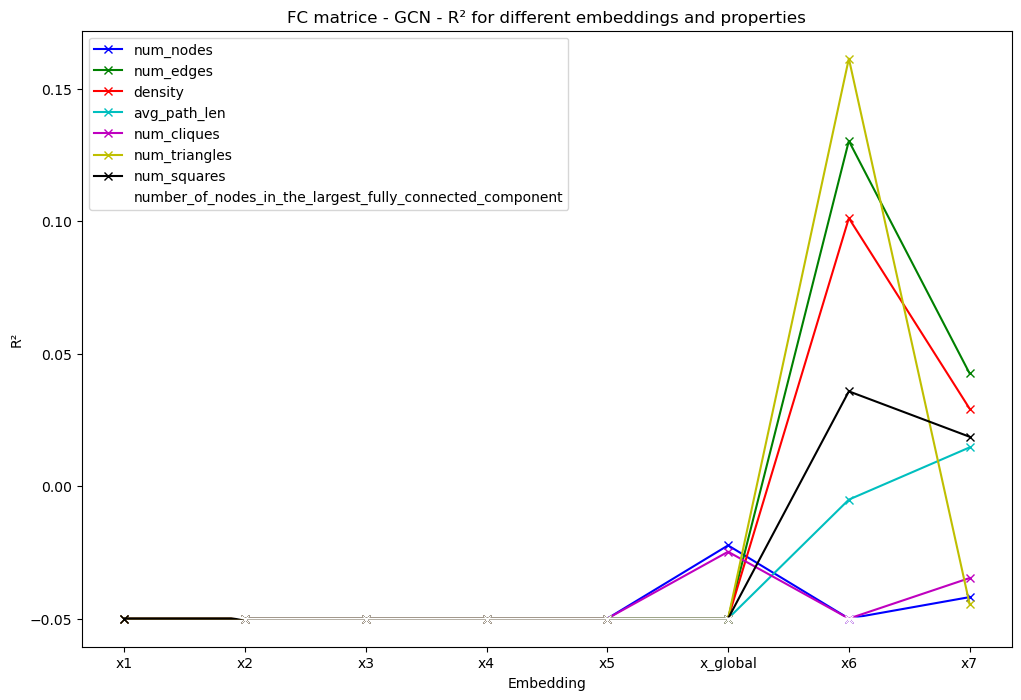

<Figure size 640x480 with 0 Axes>

In [20]:
import matplotlib.pyplot as plt

# Assuming results, embeddings, and other necessary variables are defined as in your context
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component']
embeddings_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

plt.figure(figsize=(12, 8))

for i, property_name in enumerate(property_names):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        test_r2 = results[(name_of_embedding, property_name)][3]
        if test_r2 < -0.05:  # Handle negative R² values
            test_r2 = -0.05
        x_points.append(j)
        y_points.append(test_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_name, color=colors[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/'+DATASET+"_"+MODEL+'_test_R2_plot_limited_cv.png', dpi=300, bbox_inches='tight')

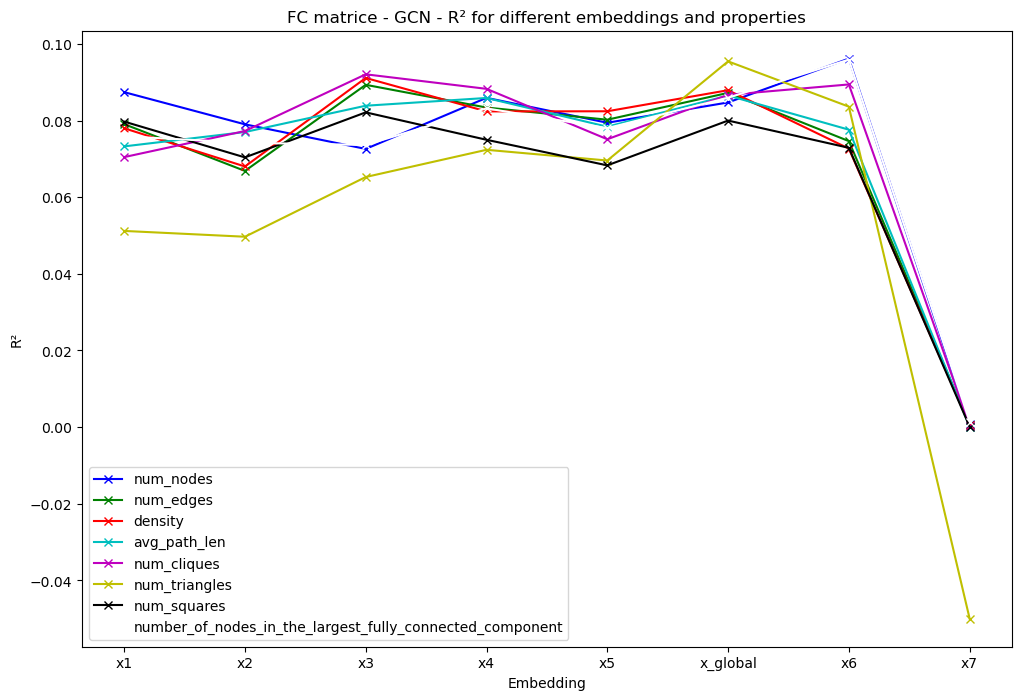

<Figure size 640x480 with 0 Axes>

In [21]:
# Assuming results, embeddings, and other necessary variables are defined as in your context
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component']
embeddings_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

plt.figure(figsize=(12, 8))

for i, property_name in enumerate(property_names):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        train_r2 = results[(name_of_embedding, property_name)][2]
        if train_r2 < -0.05:  # Handle negative R² values
            train_r2 = -0.05
        x_points.append(j)
        y_points.append(train_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_name, color=colors[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/'+DATASET+"_"+MODEL+'_train_R2_plot_limited_cv.png', dpi=300, bbox_inches='tight')

#### Test with more properties

In [22]:
import networkx as nx
import numpy as np

def calculate_avg_path_length(G):
    if nx.is_connected(G):
        return nx.average_shortest_path_length(G)
    else:
        # Use the average path length of the largest connected component for disconnected graphs
        components = [G.subgraph(c).copy() for c in nx.connected_components(G)]
        largest_component = max(components, key=len)
        return nx.average_shortest_path_length(largest_component)
    
def betweenness_centralization(G):
    n = len(G)
    betweenness = nx.betweenness_centrality(G)
    max_betweenness = max(betweenness.values())
    centralization = sum(max_betweenness - bet for bet in betweenness.values())
    if n > 2:
        centralization /= (n - 1) * (n - 2) / 2
    return centralization

def pagerank_centralization(G, alpha=0.85):
    n = len(G)
    pagerank = nx.pagerank(G, alpha=alpha)
    max_pagerank = max(pagerank.values())
    centralization = sum(max_pagerank - pr for pr in pagerank.values())
    if n > 1:
        centralization /= (n - 1)
    return centralization

def clustering_properties(G):
    average_clustering = nx.average_clustering(G)
    transitivity = nx.transitivity(G)
    return average_clustering, transitivity

def compute_graph_properties(data):
    properties = []
    for graph_data in data:
        G = nx.from_edgelist(graph_data.edge_index.t().tolist())
        
        # Number of nodes
        num_nodes = G.number_of_nodes()
        
        # Number of edges
        num_edges = G.number_of_edges()
        
        # Density
        density = nx.density(G)
        
        # Average Path Length
        avg_path_len = calculate_avg_path_length(G)
        
        # Diameter
        if nx.is_connected(G):
            diameter = nx.diameter(G)
        else:
            # Use the diameter of the largest connected component for disconnected graphs
            components = [G.subgraph(c).copy() for c in nx.connected_components(G)]
            largest_component = max(components, key=len)
            diameter = nx.diameter(largest_component)
        
        # Radius
        if nx.is_connected(G):
            radius = nx.radius(G)
        else:
            radius = nx.radius(largest_component)
        
        # Clustering Coefficient
        clustering_coeff = nx.average_clustering(G)
        
        # Transitivity
        transitivity = nx.transitivity(G)
        
        # Assortativity
        assortativity = nx.degree_assortativity_coefficient(G)
        
        # Number of Cliques
        num_cliques = len(list(nx.find_cliques(G)))
        
        # Number of Triangles
        num_triangles = sum(nx.triangles(G).values()) / 3
        
        # Number of Squares (4-cycles)
        num_squares = sum(nx.square_clustering(G).values()) / 4
        
        # Size of the Largest Connected Component
        largest_component_size = len(max(nx.connected_components(G), key=len))
        
        # Average Degree
        degrees = [d for n, d in G.degree()]
        avg_degree = np.mean(degrees)
        
        # Betweenness Centrality
        betweenness_centrality = nx.betweenness_centrality(G)
        avg_betweenness_centrality = np.mean(list(betweenness_centrality.values()))
        
        # Eigenvalues of the Adjacency Matrix (for spectral properties)
        eigenvalues = np.linalg.eigvals(nx.adjacency_matrix(G).todense())
        spectral_radius = max(eigenvalues)
        algebraic_connectivity = sorted(eigenvalues)[1]  # second smallest eigenvalue
        
        # Graph Laplacian Eigenvalues
        laplacian_eigenvalues = np.linalg.eigvals(nx.laplacian_matrix(G).todense())
        graph_energy = sum(abs(laplacian_eigenvalues))
        
        # Small-World-ness
        # Compare clustering coefficient and average path length with those of a random graph
        random_graph = nx.gnm_random_graph(num_nodes, num_edges)
        random_clustering_coeff = nx.average_clustering(random_graph)
        random_avg_path_len = calculate_avg_path_length(random_graph)
        small_world_coefficient = (clustering_coeff / random_clustering_coeff) / (avg_path_len / random_avg_path_len)

        # Calculate Betweenness Centralization
        betweenness_cent = betweenness_centralization(G)
        print(f"Betweenness Centralization: {betweenness_cent}")

        # Calculate PageRank Centralization
        pagerank_cent = pagerank_centralization(G)
        print(f"PageRank Centralization: {pagerank_cent}")

        # Calculate Clustering properties
        avg_clustering, transitivity = clustering_properties(G)
        print(f"Average Clustering Coefficient: {avg_clustering}")
        print(f"Transitivity: {transitivity}")
        
        properties.append((
            num_nodes,
            num_edges,
            density,
            avg_path_len,
            diameter,
            radius,
            clustering_coeff,
            transitivity,
            assortativity,
            num_cliques,
            num_triangles,
            num_squares,
            largest_component_size,
            avg_degree,
            avg_betweenness_centrality,
            spectral_radius,
            algebraic_connectivity,
            graph_energy,
            small_world_coefficient
        ))
    return properties

train_idx_list = gnn.train_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in train_idx_list]
train_properties_long = compute_graph_properties(selected_dataset)
test_idx_list = gnn.test_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in test_idx_list]
test_properties_long = compute_graph_properties(selected_dataset)

#save the properties in a file
with open("results/"+DATASET+"_"+MODEL+"_train_properties_long.pkl", "wb") as f:
    pkl.dump(train_properties_long, f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties_long.pkl", "wb") as f:
    pkl.dump(test_properties_long, f)



Betweenness Centralization: 0.001724022477030078
PageRank Centralization: 0.011393522233220854
Average Clustering Coefficient: 0.46590185426058695
Transitivity: 0.5531747591900924
Betweenness Centralization: 0.0017261983853566708
PageRank Centralization: 0.00892683265732043
Average Clustering Coefficient: 0.5182009816568728
Transitivity: 0.5797223390828776
Betweenness Centralization: 0.003333083015572392
PageRank Centralization: 0.015313849504207902
Average Clustering Coefficient: 0.4704590487485227
Transitivity: 0.4714022140221402
Betweenness Centralization: 0.0010671877568257148
PageRank Centralization: 0.0052237203197423076
Average Clustering Coefficient: 0.5604119583322708
Transitivity: 0.5464108308171812
Betweenness Centralization: 0.0022241433151757965
PageRank Centralization: 0.010110693464664746
Average Clustering Coefficient: 0.5817108880061148
Transitivity: 0.6164350158497928
Betweenness Centralization: 0.0008253715900658974
PageRank Centralization: 0.008937849000785933
Avera

In [23]:
#load the properties
with open("results/"+DATASET+"_"+MODEL+"_train_properties_long.pkl", "rb") as f:
    train_properties_long = pkl.load(f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties_long.pkl", "rb") as f:
    test_properties_long = pkl.load(f)

In [24]:
#print the names of the properties
# print(train_properties_long[0].keys())

#print the first element of the properties
# print(train_properties_long[0])

#copare train_properties and train_properties_long
print(train_properties[0])
print(train_properties_long[0])
print(len(train_properties_long))

(116, 488, 0.07316341829085457, 3.314842578710645, 148, 938.0, 6.439699892510922, 116)
(116, 488, 0.07316341829085457, 3.314842578710645, 7, 4, 0.46590185426058695, 0.5531747591900924, 0.4167832357774365, 148, 938.0, 6.439699892510922, 116, 8.413793103448276, 0.02030563665535653, 14.95587231892924, -4.061650998933738, 976.0000000000007, 4.553913064548185)
1523


In [25]:
property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient']
train_y_long = torch.tensor(train_properties_long, dtype=torch.float32)
test_y_long = torch.tensor(test_properties_long, dtype=torch.float32)
#create a dictionary where we will store the results for each embeddings, each property
results = {}

ii = 0

for train_embedding, test_embedding in embeddings:
    input_size = train_embedding.shape[1]

    for i, property_name in enumerate(property_names_long):
        model = LinearModel(input_size, output_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 800000  # Maximum number of epochs
        min_epochs = 1000  # Minimum number of epochs
        patience = 3000  # Number of epochs to wait for improvement
        tolerance = 1e-6  # Tolerance for considering the loss as stable

        best_loss = float('inf')
        no_improve_count = 0
        
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(train_embedding).squeeze()
            target = train_y_long[:, i].squeeze()

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 1000 == 0:  # Print every 1000 epochs
                print(f'Epoch [{epoch+1}/{num_epochs}], Property: {property_name}, Loss: {loss.item():.4f}')

            # Check for early stopping, but only after minimum epochs
            if epoch >= min_epochs:
                if loss.item() < best_loss - tolerance:
                    best_loss = loss.item()
                    no_improve_count = 0
                else:
                    no_improve_count += 1

                if no_improve_count >= patience:
                    print(f'Early stopping at epoch {epoch+1}')
                    break

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(train_embedding).squeeze().cpu().numpy()
            test_pred = model(test_embedding).squeeze().cpu().numpy()

            train_target = train_y_long[:, i].cpu().numpy()
            test_target = test_y_long[:, i].cpu().numpy()

            train_mse = mean_squared_error(train_target, train_pred)
            test_mse = mean_squared_error(test_target, test_pred)

            train_r2 = r2_score(train_target, train_pred)
            test_r2 = r2_score(test_target, test_pred)

            print(f'Embedding: {train_embedding.shape}')
            print(f'Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')

            #add the results to the dictionary
            name_of_embedding = embeddings_names[ii]
            results[(name_of_embedding, property_name)] = (train_mse, test_mse, train_r2, test_r2)

    ii += 1

#save results
with open("results/"+DATASET+"_"+MODEL+"_results_limited_cv_long.pkl", "wb") as f:
    pkl.dump(results, f)

C:\Users\tomdu\AppData\Local\Temp\ipykernel_4340\1310961172.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  train_y_long = torch.tensor(train_properties_long, dtype=torch.float32)
C:\Users\tomdu\AppData\Local\Temp\ipykernel_4340\1310961172.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  test_y_long = torch.tensor(test_properties_long, dtype=torch.float32)


Epoch [1000/800000], Property: num_nodes, Loss: 11316.3281
Epoch [2000/800000], Property: num_nodes, Loss: 10060.5898
Epoch [3000/800000], Property: num_nodes, Loss: 9020.5049
Epoch [4000/800000], Property: num_nodes, Loss: 8136.6973
Epoch [5000/800000], Property: num_nodes, Loss: 7371.2759
Epoch [6000/800000], Property: num_nodes, Loss: 6704.2192
Epoch [7000/800000], Property: num_nodes, Loss: 6122.5757
Epoch [8000/800000], Property: num_nodes, Loss: 5616.6626
Epoch [9000/800000], Property: num_nodes, Loss: 5176.6523
Epoch [10000/800000], Property: num_nodes, Loss: 4792.4106
Epoch [11000/800000], Property: num_nodes, Loss: 4454.3672
Epoch [12000/800000], Property: num_nodes, Loss: 4155.3003
Epoch [13000/800000], Property: num_nodes, Loss: 3891.3599
Epoch [14000/800000], Property: num_nodes, Loss: 3659.1582
Epoch [15000/800000], Property: num_nodes, Loss: 3454.4497
Epoch [16000/800000], Property: num_nodes, Loss: 3273.5803
Epoch [17000/800000], Property: num_nodes, Loss: 3113.6660
Epoc

In [28]:
#load results
with open("results/"+DATASET+"_"+MODEL+"_results_limited_cv_long.pkl", "rb") as f:
    results = pkl.load(f)

In [29]:
#print color_long length and property_names_long length
print(len(colors_long))
print(len(property_names_long))

19
23


In [30]:
property_names_long

'small_world_coefficient'

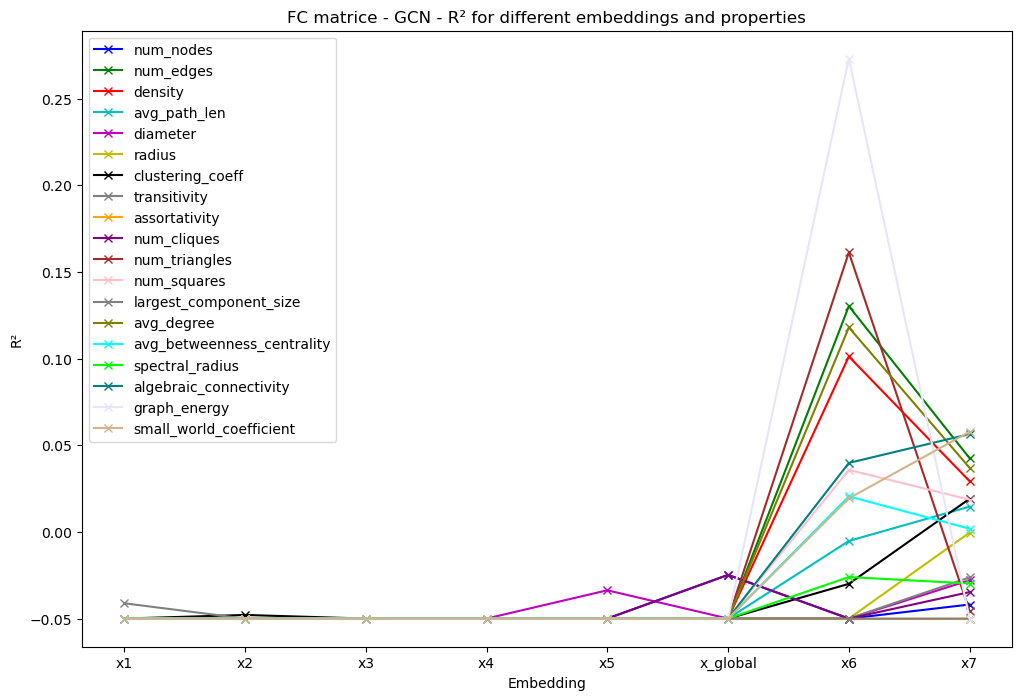

<Figure size 640x480 with 0 Axes>

In [31]:
#import plt
import matplotlib.pyplot as plt
property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient']
#make a color list for the properties names but with different colors
colors_long = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'gray', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'lime', 'teal', 'lavender', 'tan']

plt.figure(figsize=(12, 8))

for i, property_names_long in enumerate(property_names_long):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        test_r2 = results[(name_of_embedding, property_names_long)][3]
        if test_r2 < -0.05:  # Handle negative R² values
            test_r2 = -0.05
        x_points.append(j)
        y_points.append(test_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_names_long, color=colors_long[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/'+DATASET+"_"+MODEL+'_test_R2_plot_limited_cv_long.png', dpi=300, bbox_inches='tight')

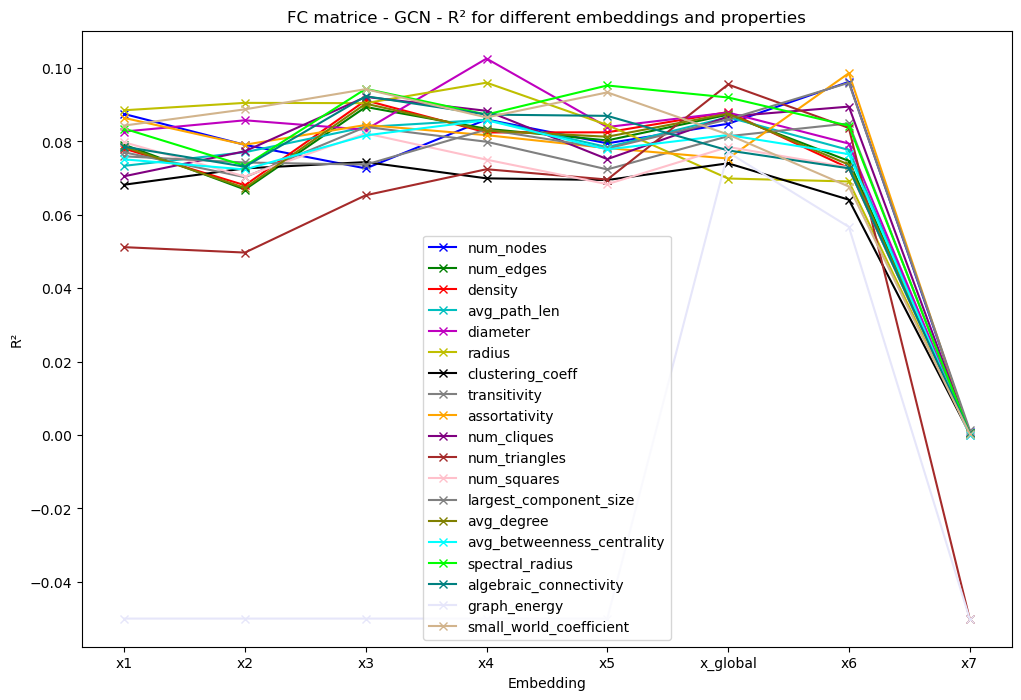

<Figure size 640x480 with 0 Axes>

In [32]:
plt.figure(figsize=(12, 8))
property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient']
colors_long = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'gray', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'lime', 'teal', 'lavender', 'tan']

for i, property_names_long in enumerate(property_names_long):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        train_r2 = results[(name_of_embedding, property_names_long)][2]
        if train_r2 < -0.05:  # Handle negative R² values
            train_r2 = -0.05
        x_points.append(j)
        y_points.append(train_r2)

    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_names_long, color=colors_long[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/'+DATASET+"_"+MODEL+'_train_R2_plot_limited_cv_long.png', dpi=300, bbox_inches='tight')
    